# Classification Metrics
    
    Evaluating Probabilistic Decisions Under Risk and Imbalance
     
## Objective

This notebook provides a structured and business-aware treatment of classification evaluation, covering:

- Confusion-matrix–based metrics

- Probability-based metrics

- Threshold-dependent vs threshold-independent evaluation

- Metric behavior under class imbalance

- Cost-sensitive interpretation

It answers:

    How do we evaluate classification models in a way that aligns with decision risk, imbalance, and business cost?


## Why Classification Metrics Are Dangerous When Misused

Classification metrics can:

- Hide severe minority-class failure

- Reward trivial majority predictors

- Encourage wrong threshold choices

- Mask cost asymmetry

- Metrics are decision instruments, not neutral scores.

## Business Context (Finance & Risk)

Classification metrics are critical in:

- Credit default prediction

- Fraud detection

- Churn modeling

- AML alerting

- Medical and compliance screening

    False positives and false negatives have asymmetric costs.

## Imports and Dataset

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    log_loss
)


df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Supervised-classification/synthetic_credit_default_classification.csv")

df.head()

,customer_id,age,annual_income,credit_utilization,debt_to_income,loan_amount,loan_term_months,num_past_defaults,employment_years,credit_score,default
0,1,59,23283.682822,0.187813,0.245248,20232.165654,24,0,4.575844,689.627408,1
1,2,49,61262.608063,0.291774,0.396763,26484.067591,36,0,3.317515,697.770541,1
2,3,35,60221.743160,0.230557,0.122859,27142.522594,24,1,11.871955,713.721429,0
3,4,63,93603.112731,0.157906,0.635484,1000.000000,12,0,2.256651,655.306417,1
4,5,28,71674.557271,0.167549,0.422446,15254.246561,48,0,6.971270,644.247643,0


In [4]:
X = df.drop(columns=["default", "customer_id"])
y = df["default"]

# Trainf test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


✔ Stratification is mandatory under imbalance.

# Baseline Model

Logistic regression as a probabilistic baseline.

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


C:\Users\pantu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Confusion Matrix

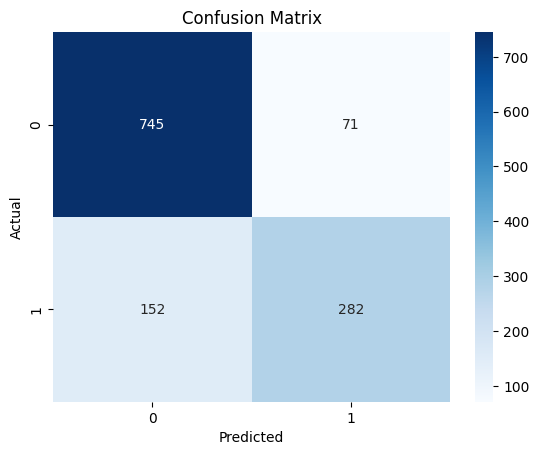

In [7]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


| Term | Meaning           |
| ---- | ----------------- |
| TP   | Correct positive  |
| FP   | False alarm       |
| FN   | Missed event      |
| TN   | Correct rejection |


## Accuracy (Why It’s Dangerous)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8216

>  Accuracy is **misleading under imbalance.**

Example:

> 95% accuracy can mean zero defaults detected.

## Precision


>> $Precision = \frac{TP}{TP + FP}$

In [10]:
precision = precision_score(y_test, y_pred)
precision


0.7988668555240793

## Recall


>> $Precision = \frac{TP}{TP + FN}$

In [11]:
recall = recall_score(y_test, y_pred)
recall


0.6497695852534562

> “Of actual positives, how many did we catch?”

Critical when false negatives are unacceptable.

##  F1 Score


> > $Precision = 2 \cdot \frac{Precision  \cdot  Recall}{Precision + Recall}$

In [12]:
f1 = f1_score(y_test, y_pred)
f1


0.7166454891994918

✔ Balances precision and recall

❌ Assumes equal cost


## ROC AUC (Threshold-Independent)

In [14]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc


np.float64(0.9056513734526068)

> Measures ranking ability, not classification accuracy.

## ROC Curve

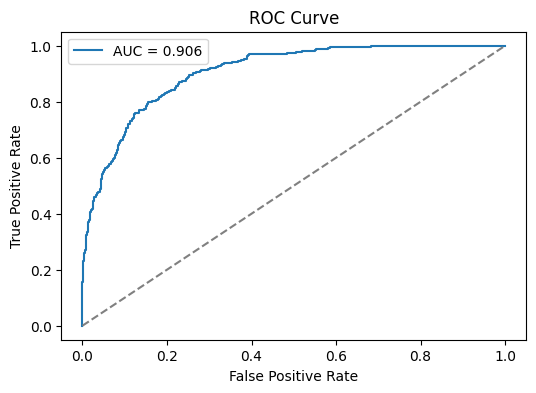

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Precision–Recall Curve (Preferred Under Imbalance)

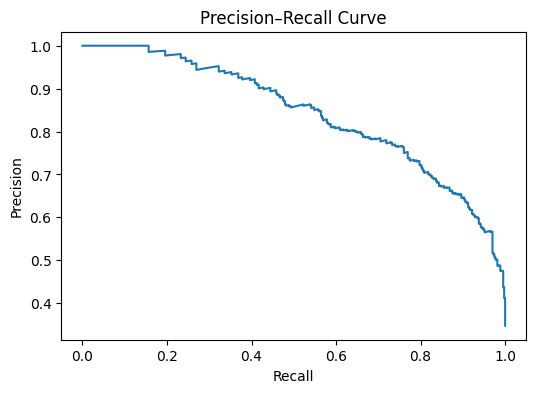

In [16]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


> ✔ More informative when positives are rare.


## Log Loss (Probability Quality)


>> $ LogLoss = - \frac{1}{n} \sum y \cdot \log{(p)} + (1-y) \log{(1-p)} $ 

In [17]:
ll = log_loss(y_test, y_prob)
ll


0.3700212056738701

✔ Penalizes overconfidence

✔ Proper scoring rule

✔ Used in credit risk modeling


## Threshold Sensitivity

Default threshold = 0.5 (arbitrary).

In [18]:
thresholds = np.linspace(0.1, 0.9, 9)

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    print(
        f"Threshold {t:.1f} | Recall: {recall_score(y_test, preds):.2f} | "
        f"Precision: {precision_score(y_test, preds):.2f}"
    )


Threshold 0.1 | Recall: 0.98 | Precision: 0.49
Threshold 0.2 | Recall: 0.93 | Precision: 0.60
Threshold 0.3 | Recall: 0.84 | Precision: 0.69
Threshold 0.4 | Recall: 0.76 | Precision: 0.76
Threshold 0.5 | Recall: 0.65 | Precision: 0.80
Threshold 0.6 | Recall: 0.57 | Precision: 0.84
Threshold 0.7 | Recall: 0.46 | Precision: 0.89
Threshold 0.8 | Recall: 0.34 | Precision: 0.94
Threshold 0.9 | Recall: 0.20 | Precision: 0.98


## Classification Report

In [19]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.91      0.87       816
           1       0.80      0.65      0.72       434

    accuracy                           0.82      1250
   macro avg       0.81      0.78      0.79      1250
weighted avg       0.82      0.82      0.82      1250



## Metric Selection by Use Case

| Use Case           | Priority Metric |
| ------------------ | --------------- |
| Fraud              | Recall          |
| Credit default     | Recall + AUC    |
| Marketing response | Precision       |
| Medical screening  | Recall          |
| Model comparison   | AUC + LogLoss   |


## Common Mistakes (Avoided)

- ❌ Using accuracy alone
- ❌ Ignoring probability calibration
- ❌ Fixing threshold at 0.5
- ❌ Comparing metrics across different prevalences
- ❌ Treating metrics as KPIs

## Summary Table

| Use Case           | Priority Metric |
| ------------------ | --------------- |
| Fraud              | Recall          |
| Credit default     | Recall + AUC    |
| Marketing response | Precision       |
| Medical screening  | Recall          |
| Model comparison   | AUC + LogLoss   |


| Metric    | Threshold | Imbalance-Safe | Use          |
| --------- | --------- | -------------- | ------------ |
| Accuracy  | Yes       | ❌              | Rarely       |
| Precision | Yes       | ✔              | FP-sensitive |
| Recall    | Yes       | ✔              | FN-sensitive |
| F1        | Yes       | ⚠              | Balanced     |
| ROC AUC   | No        | ✔              | Ranking      |
| Log Loss  | No        | ✔              | Probability  |


## Key Takeaways

- Classification metrics encode risk preferences

- Thresholds matter as much as models

- ROC ≠ Precision-Recall

- Always inspect confusion matrices

- Use multiple metrics together

06_Model_Evaluation_and_Validation/

└── [01_regression_metrics.ipynb](01_regression_metrics.ipynb)


<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)